# Determination of Experimental Parameters

In [1]:
EV_TO_JOULES = 1.6e-19
Fe_AW = 55.85 #g/mol
C_AW = 12.01 #g/mol
N_AW = 14.01 #g/mol
NA = 6.022e23 # mol^-1

## Extract some absorption fractions from CXRO

We begin by considering FeCN6.
To get started, some data is extracted from the CXRO website to get the absorption.
Inputs in this section are:

**1) Molar concentration**

**2) The jet thickness**

In [2]:
from access_CXRO import get_spectrum
from CXRO_input import make_CXRO_input

molar_con = 500 #mM
jet_thickness = 100 #um

bg_formula, bg_density, Fe_formula, Fe_density = make_CXRO_input(molar_con, True) #g/cm^3

bg_info, bg_energy, bg_spectrum = get_spectrum(bg_formula, bg_density, jet_thickness, 7100, 7190, 500)
Fe_info, Fe_energy, Fe_spectrum = get_spectrum(Fe_formula, Fe_density, jet_thickness, 7100, 7190, 500)

In [3]:
import matplotlib.pyplot as plt

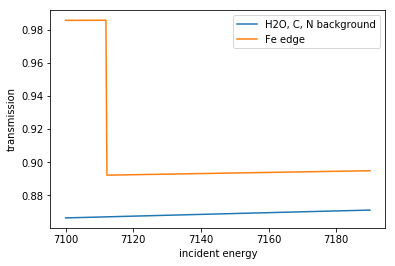

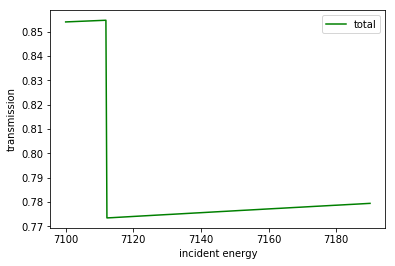

In [4]:
plt.figure()
plt.plot(bg_energy, bg_spectrum, label = 'H2O, C, N background')
plt.plot(Fe_energy, Fe_spectrum, label = 'Fe edge')
plt.xlabel('incident energy')
plt.ylabel('transmission')
plt.legend()

plt.figure()
plt.plot(bg_energy, [x*y for x,y in zip(bg_spectrum, Fe_spectrum)], label = 'total', color = 'g')
plt.xlabel('incident energy')
plt.ylabel('transmission')
plt.legend()

## Pump Pulse Parameters

Now work to determine an appropriate pump pulse parameters.  A 10% excitation rate is desired to avoid non-linear effects.  Take the Fe absorption from the previous section at the appropriate photon energy and calculate the absorption rate from this.  Inputs for this section are:

**1) Photon energy**

**2) Pulse energy**

**3) Spot diameter**

**4) Pulse duration**

Assume that every photon is absorbed by one Fe atom, so the excitation rate is the number of photon absorbed divided by the number of Fe atoms in the focus.

In [5]:
from scipy.interpolate import interp1d

pump_eV = 7188 #eV 1% from the central probe photon energy, as is determined below
pump_energy = 0.4 #uJ
spot_diameter = 120 #nm
pulse_duration = 10 #fs

f = interp1d(Fe_energy, Fe_spectrum, kind='linear')
pump_abs = 1-f(pump_eV)

N_pump_photons = pump_energy*1e-6 / EV_TO_JOULES / pump_eV

import math
focal_area = math.pi * (spot_diameter*1e-7 / 2)**2 # cm^2
focal_volume = jet_thickness*1e-4 * focal_area # cm^3
N_Fe_atoms_in_focus = Fe_density * NA / Fe_AW * focal_volume

excitation_rate = N_pump_photons * pump_abs / N_Fe_atoms_in_focus

print("The excitation rate is: {:.3f}".format(excitation_rate))

pump_fluence = pump_energy*1e-6 / focal_area / (pulse_duration*1e-15)

print("The corresponding pump fluence is: {:.1e} W/cm^2".format(pump_fluence))


The excitation rate is: 0.107
The corresponding pump fluence is: 3.5e+17 W/cm^2


We use the following paper to make sure that the fluence is not too high to cause a double core hole:

https://arxiv.org/abs/2004.11641

Assuming a 4 fs pulse, double core hole has a small probability under 10^16 W cm^-2 intensity for CO at 350 eV
Scale this by the Iron cross section

In [6]:
intensity_4fs = 2e16 # W/cm^2
carbon_CS = 3.2e4 #cm^2/g
carbon_AW = 12 #g/mol
Fe_CS = 398.3 # cm^2/g
scaled_4fs_intensity = intensity_4fs * (carbon_CS / Fe_CS * carbon_AW / Fe_AW)**2
print('Scaled intensity for a 4 fs pulse: {:.0E} W/cm^2'.format(scaled_4fs_intensity))

Scaled intensity for a 4 fs pulse: 6E+18 W/cm^2


Assuming a 80 fs pulse, double core hole has a small probability under 10^14 W cm^-2 intensity for CO at 350 eV

In [7]:
intensity_80fs = 5e14 # W/cm^2
scaled_80fs_intensity = intensity_80fs * (carbon_CS / Fe_CS * carbon_AW / Fe_AW)**2
print('Scaled intensity for a 80 fs pulse: {:.0E} W/cm^2'.format(scaled_80fs_intensity))

Scaled intensity for a 80 fs pulse: 1E+17 W/cm^2


So the pump fluence is small enough to avoid double core holes.

## Probe Pulse Parameters

### Estimate the signal

Now work to determine the necessary probe pulse parameters to have a reasonable averaging time.  Take the Fe absorption from the first section and create an anticipated signal.  From this we can extract a signal size and from photon counting estimate an averaging time for different signals.  See https://www.overleaf.com/read/zfrxymtnzkqr for more detail on the calculations necessary for creating the anticipated signal.  We will consider the 3p6 t2g4 state as our signal here.  Inputs for this section are:

**1) Min and Max spectrometer range and corresponding probe central photon energy**

**2) Proportion of photons going to upstream spectrometer**

**3) The maximum number of photons per pixel on the detector**

**4) Downstream crystal type**

**5) A peak bandwidth (known to be ~1.5 eV)**


### Summary of create_signal

We make a simplification when assembling our signal.  Technically we should use:

T_total = T_1 * T_2, 

1-A_total = (1-A_1) * (1-A_2),

A_total = A_1 + A_2 - A_1*A_2

But given the small size of our signal, we will approximate

A_total = A_1 + A_2

The generated signal uses 5 different input spectra, some of which we pass here, and some of which are read in from saved data files.

1) The background signal from CXRO from the water, C's, and N's. 

2) The Fe edge from CXRO.

3) The FeCN6 full spectrum with the edge.  This I have extracted from J. Chem. Phys. 122, 084506 (2005); https://doi.org/10.1063/1.1852455

4) Our own measurement of FeCN6 at APS.

5) The simulated spectra.

After loading in these spectra, the algorithm determines the scaling factors between them and the position of the B peaks.  The full FeCN6 edge is scaled to the Fe edge from CXRO, and then our APS FeCN6 spectra is scaled to the height of the new B peak.  Since this is our own data, I have opted to take the edge from this signal for the rest of the calculation.  The edge is then extracted from the appropriately scaled APS FeCN6 data by removing the peaks and interpolating the data.  The calculated spectra is then scaled so that the ground state APS and calculated peaks match in height and photon energy.  

The unpumped signal is composed of just the ground state spectra + the background.  Of course this is not exact but we use the assumption above to simplify computation.  

The pumped spectrum contains signal of interest.  The pumped spectra is the sum of 0.1 x excitation_rate x signal + (1-0.1 x excitation_rate)x(ground state) + (the background), with 0.1 corresponding to the amount of excited signal going to this state.   The signal is composed the same way as the ground state, with one difference, the edge is shifted by the energy difference between the signal's calculated B peak position and ground state's calculated B peak position.  This is meant to approximate how the ionization energy changes with the overall charge state.

A spectrum with no signal is also calculated by creating the same exact pumped spectrum, while ignoring roots corresponding the A peak.  

In [8]:
import numpy as np
from expected_signal import create_signal
spectra_energy, pumped, pumped_no_signal, unpumped = create_signal(bg_energy, bg_spectrum, Fe_energy, Fe_spectrum, excitation_rate)

(0.22025015244180288, 0.2790263462384548)

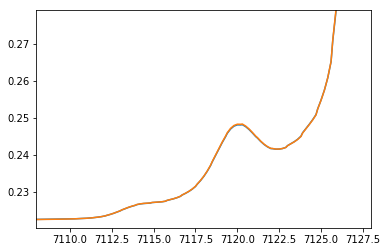

In [9]:
def find_nearest_y(array, y_array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return y_array[idx]

plt.figure()
plt.plot(spectra_energy, pumped)
plt.plot(spectra_energy, unpumped)
plt.xlim([7108, 7128])
plt.ylim([find_nearest_y(spectra_energy, pumped, 7108)*.99, find_nearest_y(spectra_energy, pumped, 7126)])

#### Note:
The bandwidth here is slightly larger than the bandwidth of the pulses (18 eV vs 15 eV = 7108*1.002).
It may be necessary to move the central energy of the pulse toward 7108 eV -> 7115.5 eV rather than 7117 eV.

(-1.1677341799548602e-05, 5.982723556394177e-06)

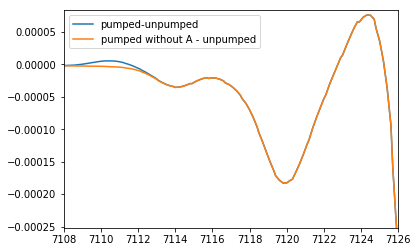

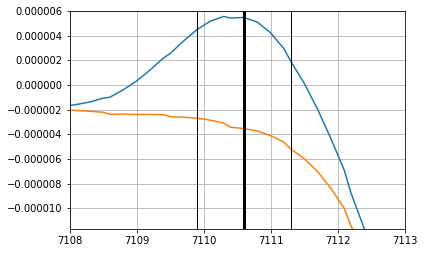

In [10]:
A_bandwidth = 1.5 #eV
min_eV = 7108 #eV
max_eV = 7126 #eV

plt.figure()
plt.plot(spectra_energy, pumped-unpumped, label = 'pumped-unpumped')
plt.plot(spectra_energy, pumped_no_signal-unpumped, label = 'pumped without A - unpumped')
plt.xlim([min_eV, max_eV])
plt.ylim([find_nearest_y(spectra_energy, pumped-unpumped, 7126), find_nearest_y(spectra_energy, pumped-unpumped, 7124.5)*1.1])
plt.legend()

diff = pumped-pumped_no_signal
A_index = np.argmax(diff)
num_pts = int(round(A_bandwidth/(spectra_energy[1]-spectra_energy[0])/2))

plt.figure()
plt.plot(spectra_energy, pumped-unpumped)
plt.plot(spectra_energy, pumped_no_signal-unpumped)
plt.plot([spectra_energy[A_index], spectra_energy[A_index]], [-10, 10], linewidth = 3, color = 'k')
plt.plot([spectra_energy[A_index+num_pts], spectra_energy[A_index+num_pts]], [-10, 10], linewidth = 1, color = 'k')
plt.plot([spectra_energy[A_index-num_pts], spectra_energy[A_index-num_pts]], [-10, 10], linewidth = 1, color = 'k')
plt.grid(which = 'major')
plt.xlim([min_eV, 7113])
plt.ylim([find_nearest_y(spectra_energy, pumped-unpumped, 7112.5),find_nearest_y(spectra_energy, pumped-unpumped, 7110.5)*1.1])

In [11]:
diff_A = diff[A_index]
print('amplitude size is: {}'.format(diff_A))

diff_mean = np.mean(diff[A_index-num_pts:A_index+num_pts])
print('mean amplitude over one bandwidth is: {}'.format(diff_mean))

amplitude size is: 9.021128474701046e-06
mean amplitude over one bandwidth is: 8.318701530750372e-06


### Pixel resolution

We will need the downstream spectrometer pixel resolution in order to determine maximally how many photons contribute to the signal if we average over portions of the peak.  It is not necessary to know the upstream pixel resolution since a) fewer photons will hit it, so it does not determine the maximal photon flux and b) it should have similar characteristics to the the downstream one.  See Appl. Phys. Lett. 101, 034103 (2012); https://doi.org/10.1063/1.4736725 for more detail.

In [12]:
from crystals import calc_div_pixel_resolution

downstream_crystal_type = 311

downstream_pixel_resolution = calc_div_pixel_resolution(downstream_crystal_type, min_eV, max_eV)
print('The downstream pixel resolution is: {:.2f} eV/pixel'.format(downstream_pixel_resolution))

The downstream pixel resolution is: 0.27 eV/pixel


### Derivation of uncertainty

To determine the necessary averaging time, I need to calculate the uncertainty associated with the change in amplitude at the A peak.  

Start with the definition of the measurement at the downstream detector (M(hv)):

M(hv) = P(hv) x (1-A(hv))

where P(hv) is the pulse spectrum (measured at the upstream detector), A(hv) is the absorption of the system, and hv is the photon energy.  

dA/A = sqrt((dM/M)^2 + (dP/P)^2)

Then assuming counting statistics and N photons in the x-ray probe pulse, with the proportion a going to the upstream spectrometer

dM/M = 1/sqrt(N x (1-a))

dP/P = 1/sqrt(N x a)

dA/A = 1/sqrt(N x a x (1-a))

dA = A/sqrt(N x a x (1-a))

N = (A/dA)^2/(a*(1-a))

### Calculation of averaging time

In [13]:
spectrometer_frac = 1/10
abs_absorption = pumped[A_index]

photon_pixel_max = 11000

def calc_ave_time(spectrometer_frac, frac_of_max, abs_absorption, diff_absorption, A_bandwidth, downstream_pixel_resolution):

    photons_over_bandwidth = photon_pixel_max * frac_of_max * round(A_bandwidth/downstream_pixel_resolution)
    photons_over_bandwidth_total = photons_over_bandwidth/(1-spectrometer_frac)
    required_photons = (abs_absorption/diff_absorption)**2/(spectrometer_frac*(1-spectrometer_frac))

    ave_time = required_photons/photons_over_bandwidth_total/120/60 #minutes
    
    return (required_photons, ave_time)

frac_of_max = 1
required_photons, ave_time = calc_ave_time(spectrometer_frac, frac_of_max, abs_absorption, \
                                           diff_mean, A_bandwidth, downstream_pixel_resolution)

print('Assuming the maximum photons on the A region, the averaging time is: {:.2f} hours'.format(ave_time/60))

frac_of_max = 1/10
required_photons, ave_time = calc_ave_time(spectrometer_frac, frac_of_max, abs_absorption, \
                                           diff_mean, A_bandwidth, downstream_pixel_resolution)

print('Assuming 1/10 the maximum photons on the A region, the averaging time is: {:.2f} hours'.format(ave_time/60))


Assuming the maximum photons on the A region, the averaging time is: 0.25 hours
Assuming 1/10 the maximum photons on the A region, the averaging time is: 2.51 hours


Looking at the C peak, which is about 10 times that of the A peak.  Assume the same absoprtion as at the A peak and the same bandwidth for simplification.

In [14]:
frac_of_max = 1
required_photons, ave_time = calc_ave_time(spectrometer_frac, frac_of_max, abs_absorption, \
                                           diff_mean*10, A_bandwidth, downstream_pixel_resolution)

print('Assuming the maximum photons on the C region, the averaging time is: {:.2f} minutes'.format(ave_time))

frac_of_max = 1/10
required_photons, ave_time = calc_ave_time(spectrometer_frac, frac_of_max, abs_absorption, \
                                           diff_mean*10, A_bandwidth, downstream_pixel_resolution)

print('Assuming 1/10 the maximum photons on the C region, the averaging time is: {:.2f} minutes'.format(ave_time))

Assuming the maximum photons on the C region, the averaging time is: 0.15 minutes
Assuming 1/10 the maximum photons on the C region, the averaging time is: 1.51 minutes


### Calculation of the probe pulse characteristics given everything above

We see that a 1/10 fraction of the maximum photons on each pixel is sufficient for a reasonable averaging time.  Therefore we work from this number to calculate total number of photons in each pulse and then the total pulse energy.

In [15]:
photons_per_pixel = photon_pixel_max * frac_of_max
n_pixels_over_range = (max_eV-min_eV)/downstream_pixel_resolution
N_probe_photons = n_pixels_over_range*photons_per_pixel/(1-spectrometer_frac)
probe_eV = (max_eV+min_eV)/2
probe_energy = N_probe_photons*probe_eV*EV_TO_JOULES*1e9 #nJ

print('The necessary pulse energy is: {:.3f} nJ'.format(probe_energy))

The necessary pulse energy is: 0.093 nJ


The necessary photon energy for the second pulse is so low, that likely we will just take whatever photon energy is easiest to generate and use some filters to reduce the number of photons striking the detector.

## Calculation of the necessary sample

We use the paper here to determine the flow rates and estimate the amount of sample required.
https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.93.034501

Necessary inputs for this section are:

**1) Tube radius**

In [16]:
FeCN6_aw = Fe_AW+(C_AW+N_AW)*6

WATER_VISCOSITY = 8.90e-4 # Pa*s N*s/m^2 @ 25C Note @ 20C 1.0016E-3, @ 30C 7.9722E-4
SURFACE_TENSION = 0.07197 # N/m @ 25 C
WATER_DENSITY = 997.0 # kg/m^3 @ 25 C
WE_J = 0.8 # Weber number for jetting > 0.8
tube_radius = 125e-6 / 2.0 # m
loss_rate = 1

jet_flow = math.sqrt((WE_J * (math.pi**2) * (tube_radius**3) * SURFACE_TENSION) / WATER_DENSITY) *1e6*60 # mL/minute
nec_volume = jet_flow * loss_rate *60*12*4*1e-3 # L
nec_mass = molar_con * nec_volume * Fe_AW / 1000 # g

print('We will need at least {:.1F} liters of solution and {:.0F} grams of solute for four shifts'.format(nec_volume, nec_mass))

We will need at least 2.0 liters of solution and 57 grams of solute for four shifts


## Summary of chosen and determined values

In [17]:
print('molar concentration: {} mM'.format(molar_con))
print('jet thickness: {} microns'.format(jet_thickness))
print('volume of solution: {:.1f} L'.format(nec_volume))
print('mass of solute: {:.0f} g'.format(nec_mass))
print('pump photon energy: {} eV'.format(pump_eV))
print('pump pulse energy: {:.2f} uJ'.format(pump_energy))
print('probe photon energy: {} eV'.format((max_eV+min_eV)/2))
print('probe pulse energy: {:.3f} nJ'.format(probe_energy))
print('pulse durations: {} fs'.format(pulse_duration))
print('spot diameter: {} nm'.format(spot_diameter))
print('downstream crystal type: {}'.format(downstream_crystal_type))
print('downstream spectrometer range: {} to {} eV'.format(min_eV, max_eV))
print('necessary spectral resolution: {} eV'.format(A_bandwidth))

molar concentration: 500 mM
jet thickness: 100 microns
volume of solution: 2.0 L
mass of solute: 57 g
pump photon energy: 7188 eV
pump pulse energy: 0.40 uJ
probe photon energy: 7117.0 eV
probe pulse energy: 0.093 nJ
pulse durations: 10 fs
spot diameter: 120 nm
downstream crystal type: 311
downstream spectrometer range: 7108 to 7126 eV
necessary spectral resolution: 1.5 eV
